<a href="https://colab.research.google.com/github/alouwyck/vives-deep-learning/blob/main/topic3/Chollet_HFST3_no_solutions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

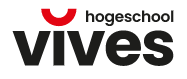<br>


**DEEP LEARNING**<br>
Academiejaar 2022-2023<br>
Andy Louwyck

---



---



# **3. Introduction to Keras and TensorFlow**

Deze notebook bevat de codevoorbeelden van paragrafen 3.5 en 3.6 uit hoofdstuk 3 van het boek "Deep Learning with Python" (2e editie) van François Chollet.

## 3.5. First steps with TensorFlow

Om een neuraal netwerk te trainen hebben we de volgende zaken nodig:

- **Low-level** tensormanipulaties = **TensorFlow** API:

  - tensors + variables
  - tensoroperaties (bv. optelling, matrixvermenigvuldiging, activatiefuncties)
  - backpropagation mbv `GradientTape` object

- **High-level** deep learning concepten = **Keras** API
  - modellen (bv. `Sequential`) die bestaan uit lagen (bv. `Dense`)
  - lossfuncties (bv. RMSE)
  - optimizers (bv. RMSprop)
  - evaluatiemetrieken (bv. accuracy)
  - training loop die mini-batch SGD uitvoert

### Constant tensors and variables

In [ ]:
import tensorflow as tf
import numpy as np

Tensoren met enen en nullen:

In [ ]:
x = tf.ones(shape=(2, 1))  # equivalent met np.ones(shape=(2, 1))
print(x)

In [ ]:
y = tf.zeros(shape=(2, 1))  # equivalent met np.zeros(shape=(2, 1))
print(y)

Random tensors:

In [ ]:
# standaardnormaal verdeelde random getallen
x = tf.random.normal(shape=(3, 1), mean=0., stddev=1.)  # cfr np.random.normal(size=(3, 1), loc=0., scale=1.)
print(x)

In [ ]:
# uniform verdeelde random getallen tussen 0 en 1
y = tf.random.uniform(shape=(3, 1), minval=0., maxval=1.)  # cfr np.random.uniform(size=(3, 1), low=0., high=1.)
print(y)

Let op! TensorFlow tensoren zijn niet 'assignable':

In [ ]:
try:
    x[0, 0] = 0.
except TypeError as err:  # geeft een TypeError
    print(err)

Oplossing: TensorFlow variables!

In [ ]:
v = tf.Variable(initial_value=tf.random.normal(shape=(3, 1)))
print(v)

Toekenning gebeurt mbv methode `assign`:

In [ ]:
v.assign(tf.ones((3, 1)))
print(v)

In [ ]:
v[0, 0].assign(3.)
print(v)

Methodes `assign_add` en `assign_sub` zijn equivalent met `+=` en `-=`:

In [ ]:
v.assign_add(tf.ones((3, 1)))

### Tensor operations: doing math in TensorFlow

In [ ]:
a = 4 * tf.ones((2, 2))
print(a)

In [ ]:
b = tf.square(a)  # kwadraat, cfr np.square()
print(b)

In [ ]:
c = tf.sqrt(a)  # vierkantswortel, cfr np.sqrt()
print(c)

In [ ]:
d = b + c  # optelling
print(d)

In [ ]:
e = tf.matmul(a, b)  # matrixvermenigvuldiging, cfr np.dot()
print(e)

In [ ]:
e *= d  # elementsgewijze vermenigvuldiging
print(e)

Alle bewerkingen worden 'on the fly' uitgevoerd = **eager execution**.

### A second look at the `GradientTape` API

Tot nu toe hebben we nog niks gedaan wat we niet in NumPy kunnen doen. Automatisch gradiënten berekenen van expressies die differentieerbaar zijn is echter iets wat we niet kunnen doen in NumPy maar wel in TensorFlow! We gebruiken hiervoor de `GradientTape`:

In [ ]:
input_var = tf.Variable(initial_value=3.0)
with tf.GradientTape() as tape:
    result = tf.square(input_var)
gradient = tape.gradient(result, input_var)  # afgeleide van x**2 voor x = 3
print(gradient)  # moet 2 * x = 6 geven

`GradientTape` kan ook toegepast worden op een lijst van inputs en op meerdimensionale tensoren. Bij een neuraal netwerk zullen we de gradient van de loss berekenen tov de gewichten:

> `gradients = tape.gradient(loss, weights)` zijn.

In het voorbeeld hebben we een `Variable` gebruikt. Met een constante tensor lukt het ook, maar dan moeten we `tape.watch()` gebruiken om de tensoroperaties 'op te nemen':

In [ ]:
input_const = tf.constant(3.0)
with tf.GradientTape() as tape:
    tape.watch(input_const)  # watch constant
    result = tf.square(input_const)
gradient = tape.gradient(result, input_const)
print(gradient)

Waarom dat 'watchen'? Om resources te sparen! De gradiënt berekenen tov 'trainable variables' is zeer gebruikelijk in deep learning, maar tov constanten niet. Daarom moet je expliciet aangeven dat je de operaties wil 'tracken' waar die constante in betrokken is.

De gradiënt is ook een functie en dus kunnen we de gradiënt van een gradiënt berekenen. Dat lukt ook in TensorFlow.

Neem als voorbeeld de versnelling $a$ die de afgeleide is van de snelheid $v$ naar de tijd $t$, terwijl de snelheid $v$ de afgeleide is van de positie $x$ naar de tijd $t$:

> $x = c t^2$

> $v = \frac{dx}{dt}$

> $a = \frac{dv}{dt} = \frac{d^2x}{dt^2}$

Stel dat $c$ een constante gelijk aan 4.9 is. Dan kunnen we de snelheid $v$ en versnelling $a$ eenvoudig als volgt berekenen:

In [ ]:
t = tf.Variable(10.0)  # pas op! 10.0 ipv 10 want moet float zijn!
with tf.GradientTape() as outer_tape:
    with tf.GradientTape() as inner_tape:
        x = 4.9 * t**2
    v = inner_tape.gradient(x, t)
a = outer_tape.gradient(v, t)
print(v)
print(a)

We nemen nu $x = c \sqrt(t)$ en berekenen 100 punten mbv `tf.linspace` om daarna een plot te kunnen maken:

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100

t = tf.linspace(start=1.0, stop=100.0, num=100)  # cfr np.linspace(1, 100, 100)
with tf.GradientTape() as outer_tape:
    outer_tape.watch(t)  # t is een constante tensor!
    with tf.GradientTape() as inner_tape:
        inner_tape.watch(t)  # t is een constante tensor!
        x = 4.9 * tf.sqrt(t)
    v = inner_tape.gradient(x, t)
a = outer_tape.gradient(v, t)

plt.plot(t, x, 'k-', t, v, 'b-', t, a, 'r-');
plt.xlabel('t');
plt.legend(['x', 'v', 'a']);
plt.grid();

`GradientTape` kan ook samengestelde functies differentiëren, bijv.:

> $z = cos(x^2)$

We weten dat de afgeleiden gelijk is aan:

> $\frac{dz}{dx}=-2x.sin(x^2)$

In [ ]:
x = tf.linspace(start=-2*np.pi, stop=2*np.pi, num=1000)
with tf.GradientTape() as tape:
    tape.watch(x)  # t is een constante tensor!
    z = tf.cos(tf.square(x))
dzdx = tape.gradient(z, x)

plt.plot(x, z, 'k-', # functie z
         x, dzdx, 'r-',  # afgeleide van z berekend met GradientTape
         x, -2*x*tf.sin(tf.square(x)), 'k:');  # analytisch berekende afgeleide van z
plt.xlabel('$x$');
plt.legend(['$z = cos(x^2)$', '$dz/dx$']);
plt.grid();

**Opdracht**

Neem de volgende veeltermfunctie:

> $y = \frac{1}{16}(231x^6-315x^4+105x^2-5)$

Maak een plot van deze functie over het interval $[-1, 1]$. Voeg onder deze plot een grafiek toe van de afgeleide $\frac{dy}{dx}$ van deze functie. Bereken deze afgeleide met de TensorFlow `GradientTape`.

### An end-to-end example: a linear classifier in pure TensorFlow

Lineaire classifiers hebben we uitvoerig in het vak Machine Learning besproken: **perceptron** en **logistic regression**. Daar hebben we ook SGD toegepast om deze modellen te trainen en we hebben het algoritme zelf geïmplementeerd in NumPy. Hier doen we het in TensorFlow.

Eerst creëren we een fictieve dataset voor binaire classificatie:

In [ ]:
import numpy as np

num_samples_per_class = 1000
negative_samples = np.random.multivariate_normal(
    mean=[0, 3],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class
)
positive_samples = np.random.multivariate_normal(
    mean=[3, 0],
    cov=[[1, 0.5],[0.5, 1]],
    size=num_samples_per_class
)

inputs = np.vstack((negative_samples, positive_samples)).astype(np.float32)
targets = np.vstack(
    (np.zeros((num_samples_per_class, 1), dtype="float32"),  # negatives = 0
     np.ones((num_samples_per_class, 1), dtype="float32"))   # positives = 1
)

plt.scatter(inputs[:, 0], inputs[:, 1], c=targets[:, 0]);
plt.grid()

We starten met het initialiseren van de gewichten en de bias:

In [ ]:
input_dim = 2
output_dim = 1
W = tf.Variable(initial_value=tf.random.uniform(shape=(input_dim, output_dim)))  # random numbers
b = tf.Variable(initial_value=tf.zeros(shape=(output_dim, )))  # nullen

print(W.numpy())  # Variable omzetten naar numpy array
print()
print(b.numpy())

De forward pass wordt als volgt gecodeerd:

In [ ]:
def model(inputs):
    return tf.matmul(inputs, W) + b  # dot(inputs, W) + b

Als lossfunctie nemen we de MSE (= mean squared error):

In [ ]:
def square_loss(targets, predictions):
    per_sample_losses = tf.square(targets - predictions)  # squared losses
    return tf.reduce_mean(per_sample_losses)  # gemiddelde

De functie voor één stap in de training loop zit er als volgt uit:

In [ ]:
learning_rate = 0.1

def training_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs)
        loss = square_loss(targets, predictions)
    grad_loss_wrt_W, grad_loss_wrt_b = tape.gradient(loss, [W, b])
    W.assign_sub(grad_loss_wrt_W * learning_rate)  # W -= grad(loss, W) * learning_rate
    b.assign_sub(grad_loss_wrt_b * learning_rate)  # b -= grad(loss, b) * learning_rate
    return loss

Bij het trainen passen we full batch SGD toe. D.w.z. dat we de gewichten updaten obv de volledige dataset ipv obv mini-batches:

In [ ]:
for step in range(50):  # we nemen 50 epochs
    loss = training_step(inputs, targets)
    print(f"Loss at step {step}: {loss:.4f}")

We pltten het resultaat waarbij voorspellingen > 0.5 afgebeeld worden op 1 en de rest op 0. De classifier heeft dus de volgende vergelijking:

> $W_0 x + W_1 y + b = 0.5$

met $x$ en $y$ de 2 features. Hieruit kunnen we de vergelijking van de scheidende rechte afleiden:

> $y = -\frac{W_0}{W_1}x - \frac{b-0.5}{W_1}$

In [ ]:
x = np.linspace(-1, 4, 100)
y = - W[0] / W[1] * x + (0.5 - b) / W[1]  # scheidende rechte
plt.plot(x, y, "-r");

predictions = model(inputs)
plt.scatter(inputs[:, 0], inputs[:, 1], c=predictions[:, 0] > 0.5);  # drempel = 0.5
plt.grid();

**OPDRACHT**

Implementeer Logistic Regression mbv TensorFlow. Gebruik dus de juiste TensorFlow functie als activatiefunctie. Voor de lossfunctie kan je ook gebruik maken van TensorFlow/Keras: https://www.tensorflow.org/api_docs/python/tf/keras/losses. Voorzie ook een methode om de nauwkeurigheid te berekenen: https://www.tensorflow.org/api_docs/python/tf/keras/metrics.

Werk niet met losse stukjes code, maar structureer alles in een klasse. Test je code uit op de dataset die hierboven werd gecreëerd.

**OPDRACHT**

Werkt je code ook voor de Halloween Candy dataset?

Lees deze dataset in en test uit door te classificeren obv feature 'chocolate'.

Vergelijk je resultaat met het Scikit-Learn algoritme.

## 3.6. Anatomy of a neural network: understanding core Keras APIs

Deze code demonstreert hoe Keras modellen (= neurale netwerken) zijn opgebouwd adhv lagen. Een laag (Engels: layer) is de belangrijkste structuur in Keras, want alles is een `Layer` of interageert met layers. De "traditionele" laag is een `Dense` layer, een volledig geconnecteerde laag. Hieronder volgt een eenvoudige implementatie van deze klasse.

In [ ]:
import tensorflow as tf
from tensorflow import keras

class SimpleDense(keras.layers.Layer):

    def __init__(self, units, activation=None):
        # units = aantal cellen = output size
        # activation = tensorflow activatiefunctie
        super().__init__()
        self.units = units
        self.activation = activation
        self.built = False

    def build(self, input_shape):
        # initialiseert de parameters W en b
        input_dim = input_shape[-1]
        self.W = self.add_weight(shape=(input_dim, self.units), initializer="random_normal")
        self.b = self.add_weight(shape=(self.units,), initializer="zeros")

    def call(self, inputs):
        # forward loop: activation(dot(input, W) + b)
        y = tf.matmul(inputs, self.W) + self.b
        if self.activation is not None:
              y = self.activation(y)
        return y

    def __call__(self, inputs):
        # zorgt ervoor dat het object als functie kan aangeroepen worden
        # zie Python documentatie: https://docs.python.org/3/reference/datamodel.html
        if not self.built:
            self.build(inputs.shape)
            self.built = True
        return self.call(inputs)

In [ ]:
my_dense = SimpleDense(units=32, activation=tf.nn.relu)  # instantiatie
input_tensor = tf.ones(shape=(2, 784))
output_tensor = my_dense(input_tensor)  # dankzij __call__ kan object als functie aangeroepen worden
print(output_tensor.shape)  # output_tensor.shape[1] = my_dense.units = 32

De eenvoudigste deep learning modellen bestaan uit een opeenvolging van lagen. In Keras gebruiken we hiervoor de `Sequantial` klasse, een subklasse van `Model`. Doordat methode `__call__()` de shape van de input automatisch in rekening brengt, hoeven we die niet mee te geven.

In [ ]:
model = keras.Sequential([
    SimpleDense(32, activation=tf.nn.relu),
    SimpleDense(64, activation=tf.nn.relu),
    SimpleDense(32, activation=tf.nn.relu),
    SimpleDense(10, activation=tf.nn.softmax)
])